In [7]:
# importing the zipfile module 
from zipfile import ZipFile 
  
# loading the temp.zip and creating a zip object 
with ZipFile('Hindi-English_train.zip', 'r') as zObject: 
  
    # Extracting all the members of the zip  
    # into a specific location. 
    zObject.extractall( 
        path="./") 

=== Segment duration (seconds) ===
N=52825 | mean=6.10  median=5.00  p95=12.00  min=0.50  max=57.00

=== Devanagari character ratio ===
N=52825 | mean=0.524  median=0.535  p95=0.825  min=0.000  max=1.000

Utterances missing text: 0


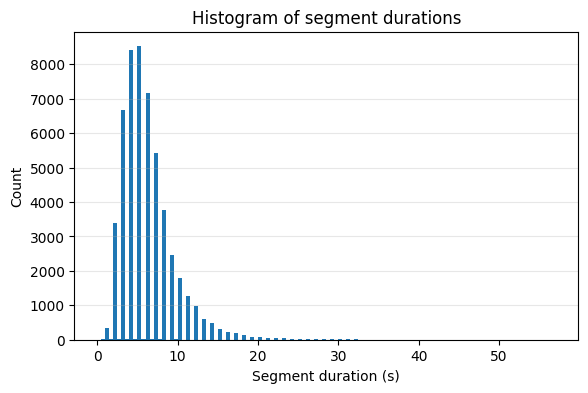

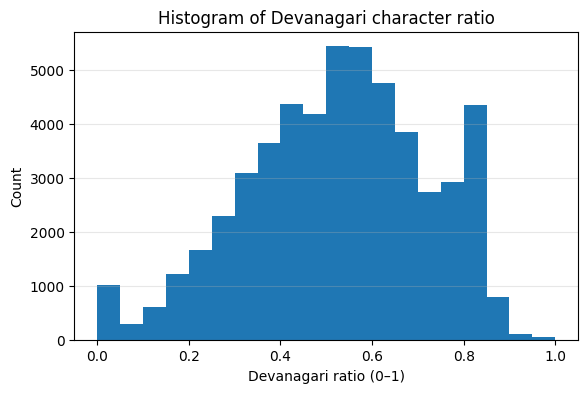

In [9]:
# === Dataset validation: duration histogram & Devanagari-ratio histogram ===
import os, re, unicodedata, numpy as np, matplotlib.pyplot as plt
from statistics import median

# --- set your dataset root (where the "transcripts" folder lives) ---
DATA_ROOT = "Hindi-English_train/train"   # or "test_split" or your full data path
MANI_DIR  = os.path.join(DATA_ROOT, "transcripts")

def read_segments(path):
    seg = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            u, r, s, e = line.strip().split()[:4]
            seg[u] = (r, float(s), float(e))
    return seg

def read_text(path):
    txt = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            if not line.strip(): continue
            parts = line.strip().split(maxsplit=1)
            if len(parts) == 1:
                u, t = parts[0], ""
            else:
                u, t = parts
            txt[u] = t
    return txt

# --- load manifests ---
segments = read_segments(os.path.join(MANI_DIR, "segments"))
texts    = read_text(os.path.join(MANI_DIR, "text"))

# --- compute segment durations ---
durations = np.array([e - s for (_, (rid, s, e)) in segments.items()], dtype=np.float32)

# --- Devanagari ratio per utterance (fraction of chars in U+0900–U+097F) ---
def dev_ratio(s: str) -> float:
    if not s: return 0.0
    s = unicodedata.normalize("NFKC", s)
    s = re.sub(r"[\u200B-\u200D\uFEFF]", "", s)  # strip zero-width
    total = len(s)
    dev   = sum(0x0900 <= ord(ch) <= 0x097F for ch in s)
    return dev / total if total else 0.0

ratios = []
missing = 0
for utt in segments.keys():
    t = texts.get(utt, "")
    if not t: missing += 1
    ratios.append(dev_ratio(t))
ratios = np.array(ratios, dtype=np.float32)

# --- print summary stats ---
def pct(x, q): 
    return float(np.percentile(x, q)) if len(x) else 0.0

print("=== Segment duration (seconds) ===")
print(f"N={len(durations)} | mean={durations.mean():.2f}  median={median(durations):.2f}  "
      f"p95={pct(durations,95):.2f}  min={durations.min():.2f}  max={durations.max():.2f}")
print("\n=== Devanagari character ratio ===")
print(f"N={len(ratios)} | mean={ratios.mean():.3f}  median={median(ratios):.3f}  "
      f"p95={pct(ratios,95):.3f}  min={ratios.min():.3f}  max={ratios.max():.3f}")
print(f"\nUtterances missing text: {missing}")

# --- plot: duration histogram ---
plt.figure(figsize=(6.5,4))
bins = np.arange(0, max(1.0, float(np.ceil(durations.max()))) + 0.5, 0.5)
plt.hist(durations, bins=bins)
plt.xlabel("Segment duration (s)")
plt.ylabel("Count")
plt.title("Histogram of segment durations")
plt.grid(axis="y", alpha=0.3)
plt.show()

# --- plot: Devanagari ratio histogram ---
plt.figure(figsize=(6.5,4))
bins_r = np.linspace(0, 1, 21)
plt.hist(ratios, bins=bins_r)
plt.xlabel("Devanagari ratio (0–1)")
plt.ylabel("Count")
plt.title("Histogram of Devanagari character ratio")
plt.grid(axis="y", alpha=0.3)
plt.show()


In [10]:
# === DATASET INTEGRITY CHECKS ===
import os, re, unicodedata, numpy as np, matplotlib.pyplot as plt
from collections import defaultdict, Counter

# point this to the same split you used above
DATA_ROOT = "Hindi-English_train/train"          # or "test_split"
MANI_DIR  = os.path.join(DATA_ROOT, "transcripts")

# ---- readers (robust to empty lines) ----
def read_wav_scp(path):
    d = {}
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line: continue
            rid, p = line.split(maxsplit=1)
            d[rid] = p
    return d

def read_segments(path):
    seg = {}
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line: continue
            u, r, s, e = line.split()[:4]
            seg[u] = (r, float(s), float(e))
    return seg

def read_text(path):
    txt = {}
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.rstrip("\n")
            if not line: continue
            parts = line.split(maxsplit=1)
            if len(parts) == 1:
                u, t = parts[0], ""
            else:
                u, t = parts
            txt[u] = t
    return txt

def read_utt2spk(path):
    m = {}
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line: continue
            u, spk = line.split()[:2]
            m[u] = spk
    return m

# ---- load manifests ----
wav_scp   = read_wav_scp(os.path.join(MANI_DIR, "wav.scp"))
segments  = read_segments(os.path.join(MANI_DIR, "segments"))
texts     = read_text(os.path.join(MANI_DIR, "text"))
utt2spk   = read_utt2spk(os.path.join(MANI_DIR, "utt2spk"))

# ---- basic cross-reference checks ----
U_seg = set(segments.keys())
U_txt = set(texts.keys())
U_u2s = set(utt2spk.keys())
R_seg = {rec for (rec, _, _) in segments.values()}
R_wav = set(wav_scp.keys())

missing_text_for_seg = sorted(U_seg - U_txt)
extra_text_no_seg    = sorted(U_txt - U_seg)
segs_ref_missing_wav = sorted(R_seg - R_wav)
utt_missing_spk      = sorted(U_seg - U_u2s)
extra_u2s_no_seg     = sorted(U_u2s - U_seg)

print("=== Cross-reference ===")
print(f"segments: {len(U_seg)}  | text: {len(U_txt)}  | utt2spk: {len(U_u2s)}  | recordings in wav.scp: {len(R_wav)}")
print(f"- Missing text for segments: {len(missing_text_for_seg)}")
print(f"- Text lines without segments: {len(extra_text_no_seg)}")
print(f"- Segments referencing missing recordings (wav.scp): {len(segs_ref_missing_wav)}")
print(f"- Utterances without speaker (utt2spk): {len(utt_missing_spk)}")
print(f"- utt2spk entries not in segments: {len(extra_u2s_no_seg)}")

# ---- timing & overlap checks ----
bad_times = []            # start>=end or negative
long_segments = []        # unusually long (threshold below)
THRESH_MAX_LEN = 30.0     # seconds (adjust for your task)
by_rec = defaultdict(list)

for u,(r,s,e) in segments.items():
    if s < 0 or e <= s:
        bad_times.append((u,r,s,e))
    if e - s > THRESH_MAX_LEN:
        long_segments.append((u,r,s,e))
    by_rec[r].append((s,e,u))

# per-recording overlap & monotonicity
overlap_count = 0
non_mono_count = 0
for r, lst in by_rec.items():
    lst_sorted = sorted(lst, key=lambda x: x[0])  # sort by start
    prev_end = -1e9
    for (s,e,u) in lst_sorted:
        if s < prev_end:      # non-monotonic or overlapping
            non_mono_count += 1
        if s < prev_end and s < e:  # actual temporal overlap
            overlap_count += 1
        prev_end = max(prev_end, e)

print("\n=== Timing checks ===")
print(f"- Bad time windows (start>=end or negative): {len(bad_times)}")
print(f"- Long segments > {THRESH_MAX_LEN:.0f}s: {len(long_segments)}")
print(f"- Non-monotonic starts within a recording: {non_mono_count}")
print(f"- Potential overlaps within a recording: {overlap_count}")

# ---- optional: verify against actual audio durations (can be slow) ----
CHECK_WAVS = False  # set True to validate s/e <= duration(file); requires torchaudio
if CHECK_WAVS:
    import torchaudio
    from functools import lru_cache
    @lru_cache(maxsize=4096)
    def _get_len_seconds(path):
        try:
            si = torchaudio.info(path)
            return si.num_frames / si.sample_rate
        except Exception:
            return None

    # try both absolute path in wav.scp and path relative to DATA_ROOT/transcripts
    def _resolve(rec_path):
        if os.path.isabs(rec_path) and os.path.exists(rec_path):
            return rec_path
        p1 = os.path.join(DATA_ROOT, rec_path)
        p2 = os.path.join(MANI_DIR, rec_path)
        return p1 if os.path.exists(p1) else (p2 if os.path.exists(p2) else rec_path)

    out_of_bounds = []
    for u,(r,s,e) in segments.items():
        rp = _resolve(wav_scp.get(r,""))
        L = _get_len_seconds(rp)
        if L is not None and (e > L + 1e-3):
            out_of_bounds.append((u,r,s,e,L))
    print(f"- Segments exceeding file duration: {len(out_of_bounds)}")

# ---- small previews if any problems ----
def _peek(lst, k=5): 
    return "\n".join(str(x) for x in lst[:k])

if missing_text_for_seg:
    print("\nExamples missing text:\n" + _peek(missing_text_for_seg))
if segs_ref_missing_wav:
    print("\nExamples seg->missing wav:\n" + _peek(segs_ref_missing_wav))
if bad_times:
    print("\nExamples bad times:\n" + _peek(bad_times))
if long_segments:
    print("\nExamples long segments:\n" + _peek(long_segments))


=== Cross-reference ===
segments: 52825  | text: 52825  | utt2spk: 52825  | recordings in wav.scp: 521
- Missing text for segments: 0
- Text lines without segments: 0
- Segments referencing missing recordings (wav.scp): 0
- Utterances without speaker (utt2spk): 0
- utt2spk entries not in segments: 0

=== Timing checks ===
- Bad time windows (start>=end or negative): 0
- Long segments > 30s: 56
- Non-monotonic starts within a recording: 0
- Potential overlaps within a recording: 0

Examples long segments:
('137649_HhvBjZURdz7XIYk7_0037', 'HhvBjZURdz7XIYk7', 218.0, 252.0)
('137649_HhvBjZURdz7XIYk7_0041', 'HhvBjZURdz7XIYk7', 284.0, 319.0)
('142176_HMnF7hnP03ktTmSa_0073', 'HMnF7hnP03ktTmSa', 850.0, 889.0)
('171660_Nyg40ltVEe5vTTsS_0026', 'Nyg40ltVEe5vTTsS', 134.0, 167.0)
('216485_FooxD8788PcEcCtL_0047', 'FooxD8788PcEcCtL', 404.0, 445.0)


Speakers: 520
Utterances per speaker — mean=101.6  median=100  p95=156
Hours per speaker      — mean=0.17  median=0.17  p95=0.26


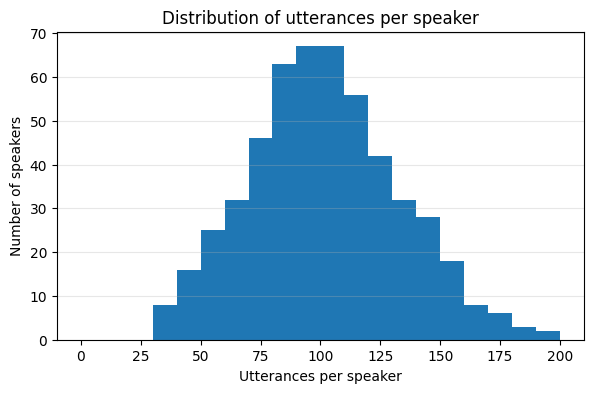

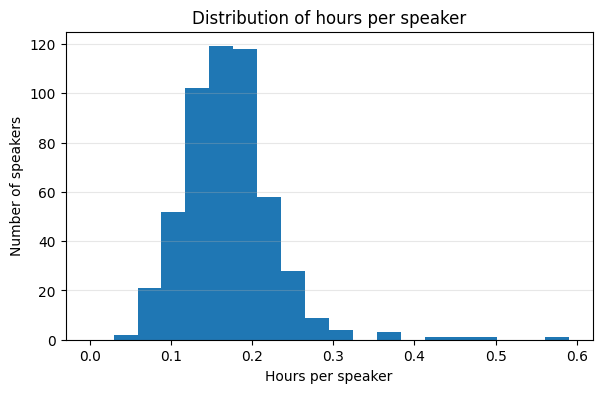

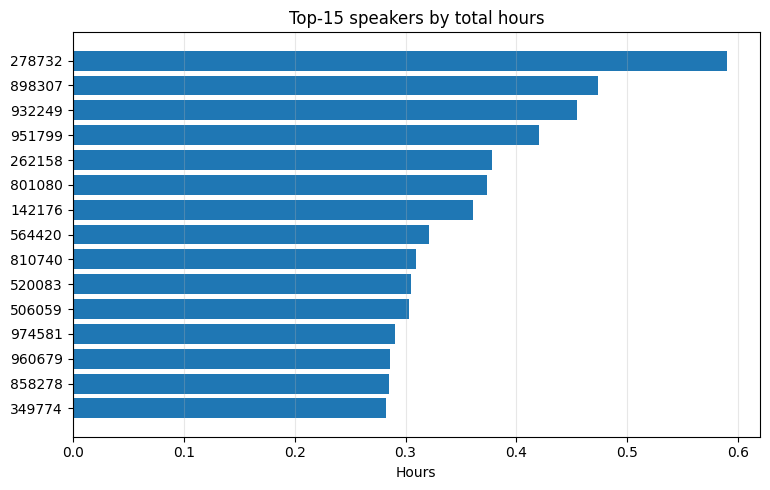

In [11]:
# === PER-SPEAKER DISTRIBUTION ===
import numpy as np, matplotlib.pyplot as plt
from collections import defaultdict
from statistics import median

DATA_ROOT = "Hindi-English_train/train"         # keep consistent
MANI_DIR  = os.path.join(DATA_ROOT, "transcripts")

# re-use readers from the previous cell if present; otherwise redefine quickly:
def read_segments(path):
    seg = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            if not line.strip(): continue
            u, r, s, e = line.strip().split()[:4]
            seg[u] = (r, float(s), float(e))
    return seg

def read_utt2spk(path):
    m = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            if not line.strip(): continue
            u, spk = line.strip().split()[:2]
            m[u] = spk
    return m

segments = read_segments(os.path.join(MANI_DIR, "segments"))
utt2spk  = read_utt2spk(os.path.join(MANI_DIR, "utt2spk"))

# --- aggregate utterance counts and total durations per speaker ---
spk_utts = defaultdict(int)
spk_secs = defaultdict(float)

for u,(r,s,e) in segments.items():
    spk = utt2spk.get(u, None)
    if spk is None: 
        continue
    spk_utts[spk] += 1
    spk_secs[spk] += max(0.0, e - s)

speakers = sorted(spk_utts.keys())
counts   = np.array([spk_utts[s] for s in speakers], dtype=np.int32)
hours    = np.array([spk_secs[s]/3600.0 for s in speakers], dtype=np.float32)

print(f"Speakers: {len(speakers)}")
print(f"Utterances per speaker — mean={counts.mean():.1f}  median={median(counts):.0f}  p95={np.percentile(counts,95):.0f}")
print(f"Hours per speaker      — mean={hours.mean():.2f}  median={median(hours):.2f}  p95={np.percentile(hours,95):.2f}")

# --- histogram: utterances per speaker ---
plt.figure(figsize=(6.8,4))
mx = max(10, counts.max())
bins = np.arange(0, mx + 5, max(1, mx//20))
plt.hist(counts, bins=bins)
plt.xlabel("Utterances per speaker")
plt.ylabel("Number of speakers")
plt.title("Distribution of utterances per speaker")
plt.grid(axis='y', alpha=0.3)
plt.show()

# --- histogram: hours per speaker ---
plt.figure(figsize=(6.8,4))
bins = np.linspace(0, max(0.1, hours.max()), 21)
plt.hist(hours, bins=bins)
plt.xlabel("Hours per speaker")
plt.ylabel("Number of speakers")
plt.title("Distribution of hours per speaker")
plt.grid(axis='y', alpha=0.3)
plt.show()

# --- (optional) Top-15 speakers by hours ---
top = np.argsort(-hours)[:15]
plt.figure(figsize=(7.8,5))
plt.barh([speakers[i] for i in top][::-1], hours[top][::-1])
plt.xlabel("Hours")
plt.title("Top-15 speakers by total hours")
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()
